In [3]:
'''

SNR 分别计算STD和ODD的SNR，然后相减，或者检验
和ASSR不一样，是需要求差异才有意义。始终都是差异波。

ERSP直接能量相减，然后才是统计（和0比，或者和DD儿童的比）
'''
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np

In [4]:

data_path = 'E:\实验\阅读困难\数据处理\pre1nanshi\data\\6epoch_equalization_oddball\\'
sub_ids = [
            'pre1006'
          ]

sub_id = sub_ids[0]
#就是单个被试的数据啊。。
epochs_std_BA = mne.read_epochs(data_path+sub_id+'_std_BA-epo.fif')
epochs_odd_TA = mne.read_epochs(data_path+sub_id+'_odd_TA-epo.fif')

Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1006_std_BA-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre1nanshi\data\6epoch_equalization_oddball\pre1006_odd_TA-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


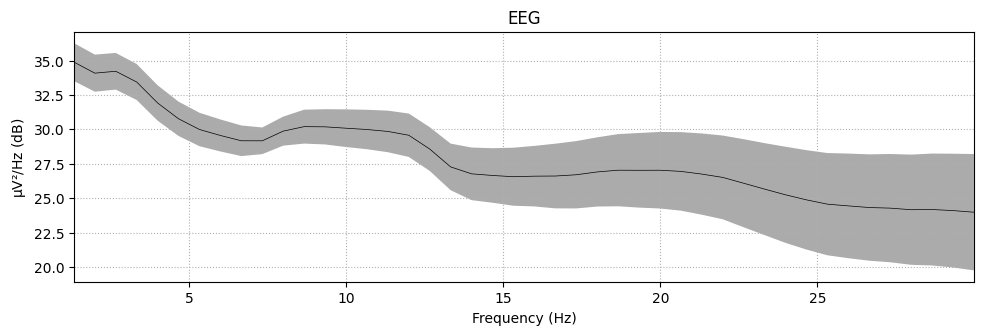

In [5]:
epochs_odd_TA.plot_psd(fmin=1.,fmax=30.,average=True,spatial_colors=False)
epochs_std_BA.plot_psd(fmin=1.,fmax=30.,average=True,spatial_colors=False)

In [6]:
'''
根据mne分析VSSR的脚本
https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html?highlight=snr

'''

tmin = 0.
tmax = 0.8
fmin = 1.
fmax = 40.
sfreq = epochs_std_BA.info['sfreq']

psds, freqs = mne.time_frequency.psd_welch(
    epochs_std_BA,
    #问题这里设置成多少好呢？
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds_odd,freqs = mne.time_frequency.psd_welch(
    epochs_odd_TA,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

In [7]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=0)
snrs_odd = snr_spectrum(psds_odd, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=0)

In [8]:
'''
需要按照channel平均之后做差
'''

fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_odd_plot = 10 * np.log10(psds_odd)

psds_mean = psds_odd_plot.mean(axis=(0, 1))[freq_range] -  psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_odd_plot.std(axis=(0, 1))[freq_range] - psds_plot.std(axis=(0, 1))[freq_range]

axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')
# SNR spectrum
snr_mean = snrs_odd.mean(axis=(0, 1))[freq_range] - snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs_odd.std(axis=(0, 1))[freq_range] - snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()

In [9]:
'''
接着看一下时频分析情况
https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py

averagebool, default True
If False return an EpochsTFR containing separate TFRs for each epoch. If True return an AverageTFR containing the average of all TFRs across epochs.
函数参数设置。
'''
#num似乎纵轴，频段的个数，要分得更细的话，就增大一些。
freqs = np.logspace(*np.log10([1, 50]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency

# 你想让他们进行相减 但是这里的power已经被平均过了
# 如果是每个被试的epochs单独拿出来算power，然后呢？
# 还是平均power的好，不然就是以试次为单位了，所以才会没有ITC。
# 应该是先计算出两个条件的平均power，然后再来相减。最后才是组间统计。
power,itc = tfr_morlet(epochs_std_BA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, average=True)
power1, itc1 = tfr_morlet(epochs_odd_TA, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, average=True)


In [10]:
# power之间可以直接相减吗？不知道其父类是不是有这个功能。
#power_m = power - power1 直接相减报错 - 考虑降级到ndarray进行相减。
# to_data_frame 函数
# 但是结果挺奇怪的。为什么只有二维。
import pandas
#datandarray, shape (n_epochs, n_channels, n_freqs, n_times) 直接取用.data就行
#所有被试的
nd_power = power.data
nd_power1 = power1.data
# 直接相减有问题的。
# 如果不相减，那就是做统计T了，感觉应该也行。
nd_power_m = nd_power1 - nd_power

In [11]:
print(nd_power)

[[[8.72767862e-10 8.66013341e-10 8.57995356e-10 ... 1.18102127e-09
   1.16546865e-09 1.14949391e-09]
  [8.06035684e-10 8.06415475e-10 8.05802886e-10 ... 1.06770648e-09
   1.04945011e-09 1.03082102e-09]
  [6.66784624e-10 6.77597442e-10 6.87774647e-10 ... 8.38574228e-10
   8.17699463e-10 7.96466702e-10]
  ...
  [2.20178355e-10 2.29120659e-10 2.37996454e-10 ... 2.42692252e-10
   2.34448868e-10 2.26019516e-10]
  [1.23751097e-10 1.28876763e-10 1.33973948e-10 ... 1.01150126e-10
   9.73960157e-11 9.36463523e-11]
  [1.02128289e-10 1.05927477e-10 1.09646023e-10 ... 1.05722993e-10
   1.01702564e-10 9.76718067e-11]]

 [[9.64992827e-10 9.54231765e-10 9.41864393e-10 ... 1.54900474e-09
   1.53914562e-09 1.52828436e-09]
  [8.99725290e-10 8.97939380e-10 8.94852231e-10 ... 1.41070203e-09
   1.39558728e-09 1.37956616e-09]
  [7.52949926e-10 7.64400263e-10 7.74980696e-10 ... 1.13706041e-09
   1.11491030e-09 1.09190064e-09]
  ...
  [1.76415558e-10 1.83501869e-10 1.90550282e-10 ... 2.40069075e-10
   2.32393

Applying baseline correction (mode: zscore)


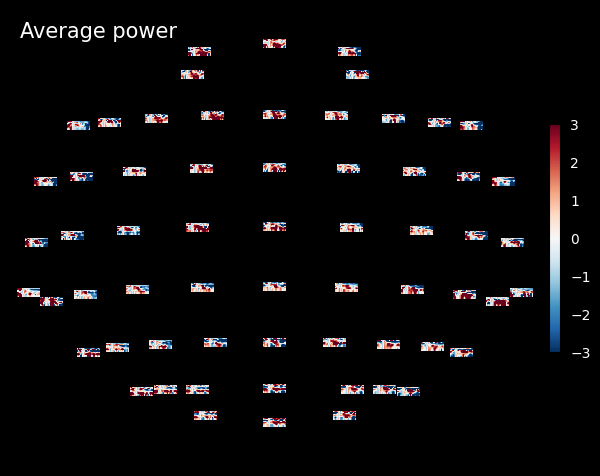

In [12]:

%matplotlib qt
# 把data幅值给数据，方便作图。
power.data = nd_power_m
power.plot_topo(baseline=(-0.2, 0), mode='zscore', title='Average power',vmin = -3,vmax = 3)


In [13]:
power.plot([33], baseline=(-0.2, 0), mode='logratio', title=power.ch_names[33])
plt.show()

Applying baseline correction (mode: logratio)


I:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


In [23]:
'''
地形图
'''
fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0, tmax=0.8, fmin=1, fmax=30,
                   baseline=(-0.2, 0), mode='logratio', axes=axis[0],
                   title='all', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: logratio)


In [34]:
'''
单个被试的ITC计算和作图
原理和power应该是一样的
'''

nd_itc = itc.data
nd_itc1 = itc1.data

# 直接相减有问题的。 m代表 minus
nd_itc_m = nd_itc1 - nd_itc
itc_m = itc.copy()
itc_m.data = nd_power_m
itc_m.plot_topo(baseline=(-0.2, 0), mode='logratio', title='Average power')
itc_m.plot([33], baseline=(-0.2, 0), mode='logratio', title=power.ch_names[33])

Applying baseline correction (mode: logratio)


I:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\baseline.py:104: RuntimeWarning: invalid value encountered in log10
  np.log10(d, out=d)


Applying baseline correction (mode: logratio)


[<Figure size 640x480 with 2 Axes>]